In [1]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.models import load_model
from keras import backend as K
from sklearn.neighbors import NearestNeighbors

import numpy as np
import sys
from glob import glob
import scipy.sparse as sp
from scipy import io

import os


from IPython.display import Image
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

import src.utils.utils as ut
import src.utils.model_utils as mu
import src.utils.sparse_matrix as sm
import src.data.dataframe as dat
import src.features.build_features as bf

Using TensorFlow backend.


/home/lisa/Schreibtisch/e-commerce


# This notebook provides an optical search routine for images

The routine is based on pre-calculated extracted image features.  To extract the features, run 
```console
make features
```
in the command line.


Each image is then represented as a vector of, in this case, 128 floats.
The similarity search is then accomplished by simple 5-NearestNeighbor classification (for sure room for improvement there).

### 1. step:  Load the data frame used for  training to get access to the filenames used in the feature extraction

In [2]:
df = dat.read_df(os.path.join(ut.dirs.processed_dir,
                              ut.df_names.cleaned_df))
filenames = df['imagename']

### 2. step:  Load the corresponding extracted features

In [3]:
load_sparse_from = os.path.join(ut.dirs.model_dir, ut.df_names.extracted_features)

if(os.path.exists(load_sparse_from) is False):
    print('no extracted features found in', ut.dirs.model_dir)
    print('run "make features" from the command line')

vecs = sm.load_sparse_matrix(load_sparse_from)

### 3. step:  Run k-NN to calculate the distances

In [4]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(vecs)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [5]:
def similar(vec):
    dist, indices = knn.kneighbors(vec.reshape(1,-1), n_neighbors=6)
    dist, indices = dist.flatten(), indices.flatten()
    return [(filenames[indices[i]], dist[i]) for i in range(len(indices))]

In [6]:
def draw(fnames, origin=None):
    
    imname = int((fname.split('/')[-1]).split('.')[0])
    cat1 = df[df['sku'] == imname]['product_category'].values[0]
    cat2 = df[df['sku'] == imname]['product_type'].values[0]
    cat3 = df[df['sku'] == imname]['product_details'].values[0]
                
    if origin is not None:
        plt.imshow(PIL.Image.open(origin))
        plt.axis('off')
    plt.figure(figsize=(30,15))
    for i in range(len(fnames)):
        f = fnames[i][0]
        sim = fnames[i][1]
        title = cat1+'\n'+cat2+'\n'+cat3+'\n'+"dist: {:1.3f}".format(sim)
        try:
            img = PIL.Image.open(f)
            plt.subplot(1,10,i+1)
            plt.axis('off')
            plt.title(title)
            plt.imshow(img)
        except Exception as e:
            print(e)

### Final step:  Test the image search

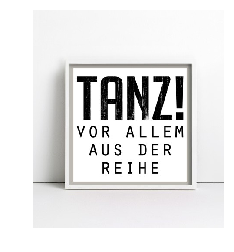

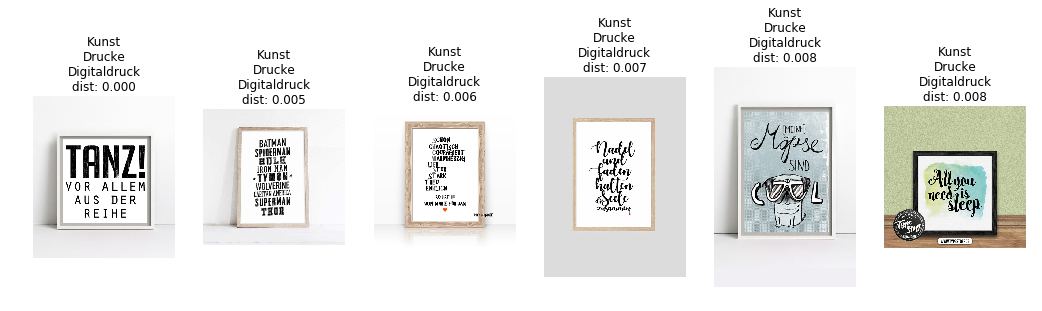

In [7]:
fname = filenames[123]

model = mu.load_pretrained_model('multilabel', 'combined')
features = bf.feature_extract(fname, model)
fnames = similar(features)

draw(similar(bf.feature_extract(fname, model)), fname)